# Aula 16 &mdash; Análise de discriminante e Naïve Bayes

Renato Vimieiro

rv2 {em} cin.ufpe.br

maio 2017

## Introdução

Na aula passada vimos o algoritmo de Regressão Logística que é usado para o problema de classificação. O uso de regressão logística, contudo, é recomendado apenas quando o número de classes é dois. Isso porque o modelo apresenta problemas de estabilidade quando o número de amostras é pequeno ou quando as classes são bem separadas (ver ISLR). Nesses casos, outros classificadores são mais recomendados. Nessa aula veremos dois classificadores que se assemelham ao modelo de regressão logística, mas que estimam a probabilidade condicional das classes dados os atributos de maneira diferente.

Como dito, o objetivo central de regressão logística era ajustar um modelo para predizer $P(Y=1~|~X)$. Pelo teorema de Bayes, sabemos que tal probabilidade condicional pode ser reescrita como

$$
P(Y=k~|~X) = \frac{P(X~|~Y=k)P(Y=k)}{P(X)}
$$.

Dessa forma, podemos enxergar o problema como a estimativa da probabilidade de se observar $X$ na classe $k$, a probabilidade de uma amostra ser da classe $k$ e a probabilidade de se observar o valor $X$. Em outras palavras, invertemos nossa análise para a probabilidade de se observar os valores nas diferentes classes. Assim, classificamos uma amostra como da classe $k$ quando seus atributos tiverem maior probabilidade de ocorrer nesta classe. Essa é a intuição por trás da Análise de discriminante e Naive Bayes.

## Análise de discriminante

A análise de discriminante supõe que os atributos sigam uma distribuição normal em cada uma das classes. No caso mais simples, linear, é assumido ainda que a variância dos atributos é a mesma em todas as classes. Portanto, o problema se resume a estimar as funções de densidade $f_k(X)$.

Se expressarmos $P(Y=k) = p_k$, podemos reescrever a equação acima como

$$
P(Y=k~|~X) = \frac{p_k~f_k(X)}{\sum p_i~f_i(X)}
$$

Iniciamos nossa análise pelo caso mais simples onde o modelo contém apenas um atributo. Como a suposição é de que os atributos sigam uma distribuição normal em cada classe com uma mesma variância $\sigma^2$, temos que

$$
f_k(X) = \frac{1}{\sigma\sqrt{2\pi}}\exp\left({-\frac{1}{2\sigma^2}(X-\bar{X_k})^2}\right)
$$

e consequentemente

$$
P(Y=k~|~X) = \frac{p_k~\frac{1}{\sigma\sqrt{2\pi}}\exp\left({-\frac{1}{2\sigma^2}(X-\bar{X_k})^2}\right)}{\sum p_i~\frac{1}{\sigma\sqrt{2\pi}}\exp\left({-\frac{1}{2\sigma^2}(X-\bar{X_i})^2}\right)}
$$

A classe da amostra $X$ é aquela com a maior probabilidade. Com alguma manipulação algébrica, pode-se verificar que o máximo da equação acima é equivalente a

$$
argmax_k(P(Y=k~|~X)) = argmax_k\log(P(Y=k~|~X)) = argmax_k \delta_k(X) = X\frac{\bar{X_k}}{\sigma^2}-\frac{\bar{X_k}^2}{2\sigma^2} + log(p_k)
$$

Assim, precisamos estimar $p_k = n_i/n$, a média de $X$ e sua variância.

Vamos retomar o exemplo da aula passada e ajustar um modelo para os dados.

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

% matplotlib inline

In [3]:
prostate = pd.read_csv("https://web.stanford.edu/~hastie/ElemStatLearn/datasets/prostate.data",
                       header=0,index_col=0,sep='\t')
prostate['prognostico'] = prostate.gleason.map(lambda x: x >=7 and 'mau' or 'bom')
treino = prostate[prostate.train=='T'].drop('train',axis=1)
teste = prostate[prostate.train=='F'].drop('train',axis=1)

In [4]:
lpk = np.log(treino.prognostico.value_counts()/treino.shape[0])
avgPSA = treino.groupby('prognostico').lpsa.mean()
varPSA = (np.sum((treino[treino.prognostico=='bom'].lpsa-avgPSA['bom'])**2)+
                np.sum((treino[treino.prognostico=='mau'].lpsa-avgPSA['mau'])**2))*(1/(treino.shape[0]-2))
deltaK = [treino.lpsa*(avgPSA[i]/varPSA)-((avgPSA[i]**2)/(2*varPSA))+lpk[i] for i in ['bom','mau']]

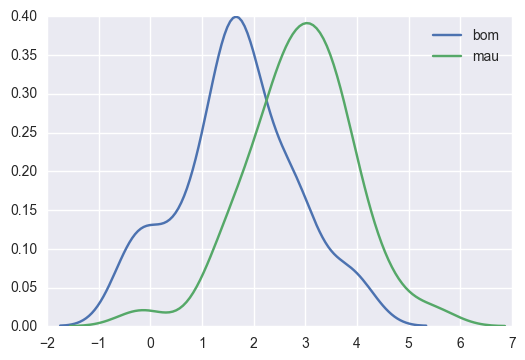

In [5]:
sns.kdeplot(treino[treino.prognostico=='bom'].lpsa,label='bom')
sns.kdeplot(treino[treino.prognostico=='mau'].lpsa,label='mau')

In [6]:
classes = np.fromiter(map(lambda x: np.argmax(np.fromiter(x,dtype='float')),zip(*deltaK)),dtype='int')
classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [7]:
pd.crosstab(classes,treino.prognostico)

prognostico,bom,mau
row_0,,
0,14,6
1,11,36


#### Caso multivariado

No caso em que $X$ corresponde a um vetor de atributos, usamos a distribuição normal multivariada, cuja função de densidade é dada por

$$
f_k(X) = \frac{1}{2\pi^{p/2}det(\Sigma)^{1/2}}\exp\left({-\frac{1}{2}(X-\mu)^T\Sigma^{-1}(X-\mu)}\right)
$$

Substituindo a função de densidade multivariada na equação de probabilidade condicional, podemos novamente constatar que seu argumento máximo é equivalente ao da função discriminante

$$
\delta_k(X) = X^T\Sigma^{-1}\mu_k-\frac{1}{2}\mu_k^T\Sigma^{-1}\mu_k+\log(p_k)
$$

Voltando ao exemplo, podemos agora incluir no modelo outros atributos como o volume e o peso da próstata. Felizmente não precisamos executar os cálculos manualmente. Podemos usar o modelo `sklearn.discriminant_analysis.LinearDiscriminant`.

In [8]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
attrs = ['lpsa','lcavol','lweight','lcp','lbph']
model = LinearDiscriminantAnalysis()
model.fit(treino[attrs],treino.prognostico.map(lambda x: x=='mau' and 1 or 0))

LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001)

In [9]:
pd.crosstab(model.predict(treino[attrs]),treino.prognostico)

prognostico,bom,mau
row_0,,
0,18,9
1,7,33


In [10]:
pd.crosstab(model.predict(teste[attrs]),teste.prognostico)

prognostico,bom,mau
row_0,,
0,6,4
1,4,16


In [11]:
model.predict_proba(teste[attrs])

array([[ 0.77402017,  0.22597983],
       [ 0.90268906,  0.09731094],
       [ 0.80471737,  0.19528263],
       [ 0.613118  ,  0.386882  ],
       [ 0.10543924,  0.89456076],
       [ 0.61839164,  0.38160836],
       [ 0.40897862,  0.59102138],
       [ 0.71431772,  0.28568228],
       [ 0.62182098,  0.37817902],
       [ 0.65799105,  0.34200895],
       [ 0.61277706,  0.38722294],
       [ 0.6590894 ,  0.3409106 ],
       [ 0.33489838,  0.66510162],
       [ 0.35651756,  0.64348244],
       [ 0.49969552,  0.50030448],
       [ 0.25928121,  0.74071879],
       [ 0.19195958,  0.80804042],
       [ 0.10048359,  0.89951641],
       [ 0.37545518,  0.62454482],
       [ 0.08787725,  0.91212275],
       [ 0.03714086,  0.96285914],
       [ 0.03814711,  0.96185289],
       [ 0.4627366 ,  0.5372634 ],
       [ 0.23620869,  0.76379131],
       [ 0.30420294,  0.69579706],
       [ 0.0350234 ,  0.9649766 ],
       [ 0.13845334,  0.86154666],
       [ 0.02600525,  0.97399475],
       [ 0.0040018 ,

#### Análise discriminante quadrática

Se abrirmos mão da suposição de que a matriz de variância e covariância é a mesma em todas as classes e tomarmos uma para cada classe, a função discriminante vista acima se transforma em uma função quadrática. A vantagem desse novo modelo é que a fronteira entre classes passa a ser não-linear (no caso mais simples uma parábola ao invés de uma reta). Por outro lado, o modelo contém muito mais parâmetros uma vez que cada matriz de covariância contribui com a estimativa de $p(p+1)/2$ parâmetros, levando a um total de $Kp(p+1)/2$ parâmetros. Essa flexibilidade pode contribuir para o aumento. A escolha de qual modelo é melhor depende sempre do conjunto de dados, mas via de regra o modelo linear deve ser a escolha quando o número de exemplos no conjunto de treinamento é pequeno.

Para exemplificar, vamos treinar o modelo quadrático com os mesmos dados e ver se há uma melhora na acurácia.

In [12]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
model = QuadraticDiscriminantAnalysis()
model.fit(treino[attrs],treino.prognostico.map(lambda x: x=='mau' and 1 or 0))

QuadraticDiscriminantAnalysis(priors=None, reg_param=0.0,
               store_covariances=False, tol=0.0001)

In [13]:
pd.crosstab(model.predict(treino[attrs]),treino.prognostico)

prognostico,bom,mau
row_0,,
0,21,9
1,4,33


In [14]:
pd.crosstab(model.predict(teste[attrs]),teste.prognostico)

prognostico,bom,mau
row_0,,
0,9,4
1,1,16


## Naive Bayes

O classificador Naive Bayes é muito similar à análise de discriminante. Nas funções discriminantes acima, nosso maior interesse foi em avaliar o valor máximo de $P(X|Y=k)P(Y=k)$. Isso pois o denominador é independente da classe. O numerador, por outro lado, é equivalente a probabilidade conjunta de $X$ e $Y$. Assim, usando as propriedades de probabilidades condicionais e conjuntas, temos que

\begin{align}
P(X|Y=k)P(Y=k) & = P(X,Y=k) = P(X_1,X_2,\dots,X_p,Y=k) \\
& = P(X_1~|~X_2,\dots,X_p,Y=k)P(X_2,\dots,X_p,Y=k) \\
                                                     & = P(X_1~|~X_2,\dots,X_p,Y=k)P(X_2|X_3,\dots,X_p,Y=k)P(X_1~|~X_2,\dots,X_p,Y=k)P(X_3,\dots,X_p,Y=k) \\
                                                     & = P(X_1~|~X_2,\dots,X_p,Y=k)\ldots P(X_p|Y=k)P(Y=k)
\end{align}

O classificador Naive Bayes assume que os atributos são independentes entre si. Logo, o modelo pode ser reescrito como

$$
P(X|Y=k)P(Y=k) = P(X,Y=k) = P(Y=k)\prod P(X_i~|~Y=k) 
$$

Portanto, temos que a probabilidade condicional de $Y$ dado $X$ é

$$
P(Y=k~|~X) = P(Y=k)\prod P(X_i~|~Y=k) 
$$

Dessa forma, basta usarmos funções de densidade para estimarmos $P(X_i~|~Y=k)$ para ajustarmos o modelo.

In [15]:
from sklearn.naive_bayes import GaussianNB 
model = GaussianNB()
model.fit(treino[attrs],treino.prognostico.map(lambda x: x=='mau' and 1 or 0))

GaussianNB(priors=None)

In [16]:
pd.crosstab(model.predict(treino[attrs]),treino.prognostico)

prognostico,bom,mau
row_0,,
0,20,10
1,5,32


In [17]:
pd.crosstab(model.predict(teste[attrs]),teste.prognostico)

prognostico,bom,mau
row_0,,
0,8,4
1,2,16


In [18]:
model.predict_proba(teste[attrs])

array([[  9.53588905e-01,   4.64110947e-02],
       [  9.95408406e-01,   4.59159404e-03],
       [  9.76165352e-01,   2.38346477e-02],
       [  7.37601945e-01,   2.62398055e-01],
       [  1.79112565e-03,   9.98208874e-01],
       [  8.97149447e-01,   1.02850553e-01],
       [  7.18938180e-01,   2.81061820e-01],
       [  9.60335980e-01,   3.96640200e-02],
       [  8.88610701e-01,   1.11389299e-01],
       [  9.46200543e-01,   5.37994570e-02],
       [  5.72224579e-01,   4.27775421e-01],
       [  6.60351546e-01,   3.39648454e-01],
       [  1.32114260e-02,   9.86788574e-01],
       [  2.76382583e-01,   7.23617417e-01],
       [  5.27991561e-01,   4.72008439e-01],
       [  4.42831638e-01,   5.57168362e-01],
       [  2.53924453e-01,   7.46075547e-01],
       [  2.38180110e-04,   9.99761820e-01],
       [  2.81004421e-01,   7.18995579e-01],
       [  5.51875580e-02,   9.44812442e-01],
       [  2.65690524e-05,   9.99973431e-01],
       [  6.94959536e-06,   9.99993050e-01],
       [  

## Gerando conjuntos de treinamento e teste com sklearn

Uma funcionalidade bastante interessante em `sklearn` é a geração de conjuntos de treinamento e teste. Obviamente, você pode separá-los manualmente, mas o pacote auxilia nessa tarefa, permitindo inclusive a amostragem estratificada.

In [19]:
from sklearn.model_selection import train_test_split

dados = prostate.drop('train',axis=1)
X_train, X_test, y_train, y_test = train_test_split(
    dados[attrs], dados.prognostico.map(lambda x: x=='mau' and 1 or 0), 
    test_size=0.3)

print(X_train.shape, np.sum(y_train), y_train.shape[0]-np.sum(y_train))
print(X_test.shape, np.sum(y_test), y_test.shape[0]-np.sum(y_test))

(67, 5) 41 26
(30, 5) 21 9


## Validação cruzada com sklearn

Outra funcionalidade de `sklearn` é a avaliação do modelo usando validação cruzada. O pacote fornece mecanismos para auxiliar na partição automática do conjunto de dados e na avaliação do modelo em cada partição. Em seguida, a função retorna os resultados obtidos para avaliação do usuário.

In [20]:
from sklearn.model_selection import cross_val_score
model = GaussianNB()
scores = cross_val_score(model, dados[attrs], 
                         dados.prognostico.map(lambda x: x=='mau' and 1 or 0), 
                         cv=5)
scores 

array([ 0.5       ,  0.75      ,  0.78947368,  0.89473684,  0.63157895])

Por padrão, a função `cross_val_score` avalia a acurácia em cada fold. Contudo, o pacote permite que outras funções de avaliação sejam usada. Basta indicar uma das funções disponíveis em http://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter como parâmetro. No exemplo a seguir, usamos a sensitividade como função de avaliação.

In [23]:
from sklearn.model_selection import StratifiedKFold
scores = cross_val_score(model, dados[attrs], 
                         dados.prognostico.map(lambda x: x=='mau' and 1 or 0),
                         scoring='recall',
                         cv=StratifiedKFold(5,shuffle=True,random_state=18))
scores 

array([ 0.53846154,  0.84615385,  0.83333333,  0.91666667,  0.83333333])